In [1]:
import sys, os
import numpy as np
from os.path import abspath, join, dirname, expanduser
sys.path.append(dirname(dirname(abspath(os.getcwd() + "../__init_.py"))))

import cupy as op
from utils.config import *
from scipy import signal
from scipy.linalg import expm
from utils.matlab_utils import *
from cupy.linalg import pinv, norm
from dynamics.dynamo import one_step_dynamics
from dynamics.dynamo_control import state_feedback_full
from cupyx.scipy.linalg import block_diag as cpblk_diag

import copy, time 
from numpy.linalg import pinv, norm
from scipy.linalg import block_diag 

import matplotlib 
%matplotlib inline 
import matplotlib.pyplot as plt 

# from explicit_integ import artificialDissipationGLF, odeCFL2, \
# 			odeCFLset,termRestrictUpdate, termLaxFriedrichs
# from grids import *

In [2]:
def get_reference_signals(tspan):
    sinusoid = 1 + np.sin(2*op.sin(tspan))
    
    u = np.linspace(0, 2.0 * op.pi, endpoint=True, num=50)
    v = np.linspace(-0.5, 0.5, endpoint=True, num=10)
    u, v = np.meshgrid(u, v)
    u, v = u.flatten(), v.flatten()

    # Mobius mapping: Taking a u, v pair and returning an x, y, z triple
    x = (1 + 0.5 * v * np.cos(u / 2.0)) * np.cos(u)
    y = (1 + 0.5 * v * np.cos(u / 2.0)) * np.sin(u)
    z = 0.5 * v * np.sin(u / 2.0)

    ref_sigs = Bundle(dict(sinusoid = sinusoid, 
                            mobius=Bundle(dict(uv=(u,v), xyz=(x,y,z)))
                                    ))

    return ref_sigs

def iterate_gain_kernel(Mn, C_1n, C_2n, Dn, tf=100):
    """
        Iterate the gain kernel to convergence using equation (26) in the paper.

        The gain kernel is given by:
            k_n(t,t) = -0.5 * M_n^{-1} \int_0^t { k_n(t,t) M_n k_n(t,t) + (C_{1n} + C_{2n} + D_n) } dt

        while the boundary controller is 
            U_n(t) = \int_0^t { q_n(t,t) + k_n(t,t) - M_n^{-1} [(C_{1n} + C_{2n} + D_n)] } dt

        Inputs:
            Mn: Mass density of the soft robot.
            Cn: Coriolis forces of the soft robot.
            Dn: Drag matrix of the robot.
            tf: final time for the simulation.

        Returns:
            k_n: All gains per time step per section per number of pieces for the soft robot.
    """
    kn          = op.zeros((tf,)+(C_2n.shape))    
    ScaledMnInv = -(1/2) * pinv(Mn)
    breve_Cn    = C_1n + C_2n

    for tp in range(1, tf):
        tpinv = 1/(tp)
        kn[tp] += ( tpinv * kn[tp-1] @ (Mn @ kn[tp-1]) + breve_Cn + Dn )
        kn[tp] *=  ScaledMnInv 

    return kn

In [3]:
tout = op.zeros((1, 5))
temp = op.ones((5))#.tolist()
tout[0,:] = op.hstack((1, 2, 3, 4, 5))
print(tout[0,:])

[1. 2. 3. 4. 5.]


Bad pipe message: %s [b'/\xbb\xe2\xf6F\x83\xc4Z\xb9\xa5\x86\\p\xd2\xa6\x0fP\x08 \xa3\xaf\xbf\xda>\xd4/|\xc8I\xa4\x9b}z\x7f/8\x9a\x03\x12\xc3\x03\x84\xe2\xd4\xc8W?\xebR\xdcp\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00']
Bad pipe message: %s [b'\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08']
Bad pipe message: %s [b'\x08\n\x08\x0b\x08\x04\x08', b'\x06\x04\x01\x05']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'']
Bad pipe message: %s [b'\x03\x02\x03\x04\x00-\x00\x02\x01\x01\x003\x00&\x00$\x00\x1d\x00 e\x10\x8b\x9a\xfaf\xf8j:\xdb\xa0k\x8a\n\xa5\xe5\xe0\xdf\xa7\xd2C\xfb']
Bad pipe message: %s [b'\xf2\x96\xdd\xcd\x8f$\xce\xc6\x08\xc25`\xb2y\xbe\xcc\xe9D\x00\x00\xa6\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9

In [3]:
num_sections     = gv.num_sections
num_pieces       = gv.num_pieces

print("num_pieces in robot ", num_pieces)
# Get the strain states 
xis = state_derivs[:6*num_pieces, :]
xi_dots = state_derivs[6*num_pieces:,:]
print(rf"xis: {xis.shape}, \dot(xis), {xi_dots.shape}")

NameError: name 'init_cond' is not defined

In [4]:
# allocate memory for gain of all sections
gains_all = np.zeros(((num_pieces,) + (xis.shape)))
print(gains_all.shape)

(4, 24, 1)


In [5]:
from math import pi 

signal.unit_impulse((2,2), idx=(1))

def tilde_one(n):
    return op.ones((n,n)) - op.eye(n)

def gain_at_t(t, Mn_shape=(24,24)):
    imp = signal.unit_impulse(Mn_shape, idx=())

def dirac_delta_lorentz(x, eps):
    return (eps/pi)*(1/(x**2 + eps**2))

def dirac_delta_lorentz_deriv(x, eps):
    return -(eps/pi)*(1/(x**2 + eps**2))

def dirac_delta_gauss(x, eps):
    return (1/eps*np.sqrt(pi))*np.exp(-x**2/eps**2)

def dirac_delta_sine(x, eps):
    return (1/pi)*np.sin(x/eps)/x

In [8]:
x = op.eye(6)
x_shifted = dirac_delta_lorentz(x, eps=0.1)
# print(x_shifted, "\n", x_shifted.shape)
# signal.unit_impulse(x_shifted, idx=(1))

Xci              = state_derivs[:6*num_pieces]
Xcidot           = state_derivs[6*num_pieces:12*num_pieces]

"Allocate memory for gain kernels"
abscissa_len     = 6   
tf               = 30
gain             = op.zeros((len(tspan), num_pieces, tf)+(6,6)) 

"Get reference Signals for Tracking"
ref_sigs = get_reference_signals(tspan)
sines    = ref_sigs.sinusoid
mobius   = ref_sigs.mobius

"save dir"
save_dir = "data"

M = op.zeros((len(tspan),)+(24,24))
C1 = op.zeros((len(tspan),)+(24,24))
C2 = op.zeros((len(tspan),)+(24,24))
D = op.zeros((len(tspan),)+(24,1))
N = op.zeros((len(tspan),)+(24, abscissa_len))
Torque = op.zeros((len(tspan),)+(24, 1))

gain_term = op.zeros((len(tspan),)+(24,24))
control_law = op.zeros((len(tspan),)+(24,24))
qdot        = op.zeros((len(tspan),)+(24,1))
qddot       = op.zeros((len(tspan),)+(24,1))

In [35]:
for t in range(len(tspan)):        
    # get the one time step dynamics
    dynamics                = one_step_dynamics(state_derivs, t)
    M[t], C1[t], C2[t], D[t]= dynamics.M, dynamics.Co1, dynamics.Co2, dynamics.DMat
    gr, N[t], Gravity, Torque[t]  = dynamics.g_r, dynamics.N, dynamics.Gravity, dynamics.Torque
    qdot[t], qddot[t]       = dynamics.qdot, dynamics.qddot
    
    # compute control law params
    mass_inv = pinv(M[t])
    cos_and_D = C1[t]+C2[t]+D[t]
    denom_term = mass_inv@(cos_and_D)
    
    "Account for the negative value of the first derivative of delta function here."
    # gain_term1    = dirac_delta_lorentz_deriv(- 2 * op.eye(abscissa_len*num_pieces), eps=0.1)
    # gain_term2    = dirac_delta_lorentz(denom_term @ tilde_one(abscissa_len*num_pieces), eps=0.1)
    gain_term1    = - 2 * op.eye(abscissa_len*num_pieces)
    gain_term2    = denom_term @ tilde_one(abscissa_len*num_pieces)

    gain_term[t]  = gain_term1 - gain_term2
    exp_term = op.asarray(expm(-denom_term.get()*t))
    control_factor = (op.eye(abscissa_len*num_pieces)-exp_term)/denom_term
    "Retrieve the sectional masses and control successively"
    control_law[t] = gain_term[t] @ control_factor


### Post-Processing

In [15]:
print(ref_sigs.sinusoid.shape, state_derivs.shape)

# calculate the derivatives and second derivatives of the sinusoidal signal
xis     = state_derivs[:6*num_pieces]
xi_dots = state_derivs[6*num_pieces:12*num_pieces]

xis_ref = pi*op.sin(xis)
xi_dots_ref = pi*op.sin(xi_dots)

xi_errs = xis_ref-xis
xi_dot_errs = xi_dots_ref - xi_dots

# we want our controller to regulate the errors to xero

(2001,) (48, 1)
[[0. 0. 0. 1. 0. 0.]] [[0. 0. 0. 0. 0. 0.]] [[0.         0.         0.         2.64355906 0.         0.        ]]


In [ ]:

sol = runge_kutta_fehlberg(state_feedback_full, init_cond, tspan)
print(f"Num fevals: {sol.nfevals}")
print(f"Sol at current time step:  {sol.z}")
print(f"Num failures at step : {sol.t}: {sol.nfevals}")

### Visualize the control law and associated controlled state

In [ ]:

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(1, 3, fig)
ax = [plt.subplot(gs[i], projection='3d') for i in range(2)] + [plt.subplot(gs[2])]


ax[0].plot_surface(tspan, )

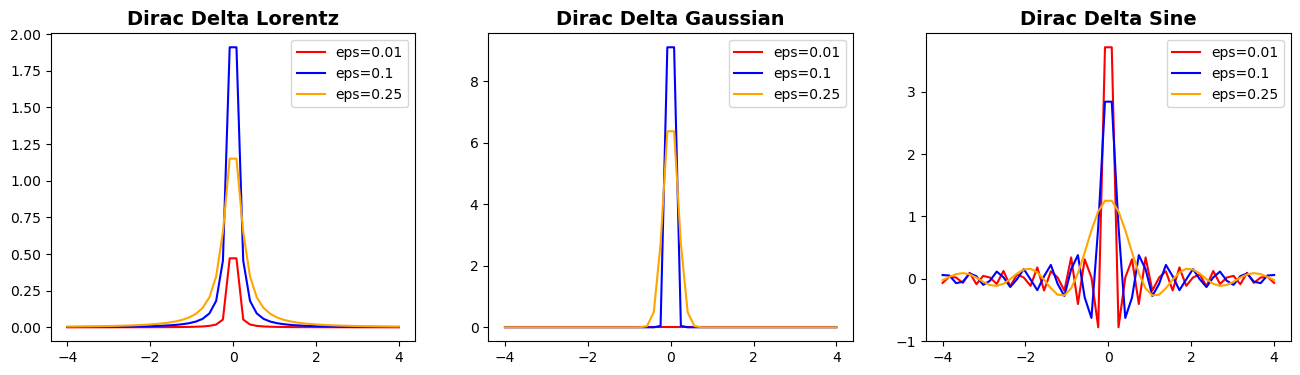

In [ ]:
# gain kernel 

x = np.linspace(-4, 4, 50)

idx, delta, delta_gauss, delta_sine = 0, [np.nan] *3, [np.nan] *3, [np.nan] *3
# for eps in [0.5, 1, 2]:
for eps in [0.01, 0.1, 0.25]:
    delta[idx] = dirac_delta_lorentz(x, eps)
    delta_gauss[idx] = dirac_delta_gauss(x, eps)
    delta_sine[idx] = dirac_delta_sine(x, eps)
    idx += 1

colors = ['red', 'blue', 'orange']
idx = 0
eps = [0.01, 0.1, 0.25]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
for delt, deltg, delts in zip(delta, delta_gauss, delta_sine):
    ax1.plot(x, delt, color=colors[idx], label = f"eps={eps[idx]}")
    ax2.plot(x, deltg, color=colors[idx], label = f"eps={eps[idx]}")
    ax3.plot(x, delts, color=colors[idx], label = f"eps={eps[idx]}")
    idx += 1

_fontdict = {'fontsize':14, 'fontweight':'bold'}    
ax1.set_title("Dirac Delta Lorentz", fontdict=_fontdict)
ax2.set_title("Dirac Delta Gaussian", fontdict=_fontdict)
ax3.set_title("Dirac Delta Sine", fontdict=_fontdict)
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax3.legend(loc="upper right")
plt.show()


finite_diff_data = Bundle(dict(innerFunc = termLaxFriedrichs,
                            innerData = Bundle({'grid': g,
                                'hamFunc': rocket_rel.hamiltonian,
                                'partialFunc': rocket_rel.dissipation,
                                'dissFunc': artificialDissipationGLF,
                                'CoStateCalc': upwindFirstENO2,
                                }),
                                positive = True,  # direction to grow the updated level set
                            ))
options = Bundle(dict(factorCFL=0.95, stats='on', singleStep='off'))

t_plot = (tspan[1] - tspan[0]) / 10
small = 100*eps
tnow = tspan[0]

while(tspan[1] - tnow > small * tspan[1]):
    itr_start.record()
    cpu_start = cputime()
    time_step = f"{t_now}/{t_range[-1]}"
			
y0 = cp.random.rand()
t, y, _ = odeCFL2(termRestrictUpdate, tspan, y0, odeCFLset(options), finite_diff_data)
			

In [ ]:
num_pieces 

4

### PLOTS: Sinusoidal Refence signal for section $n$.

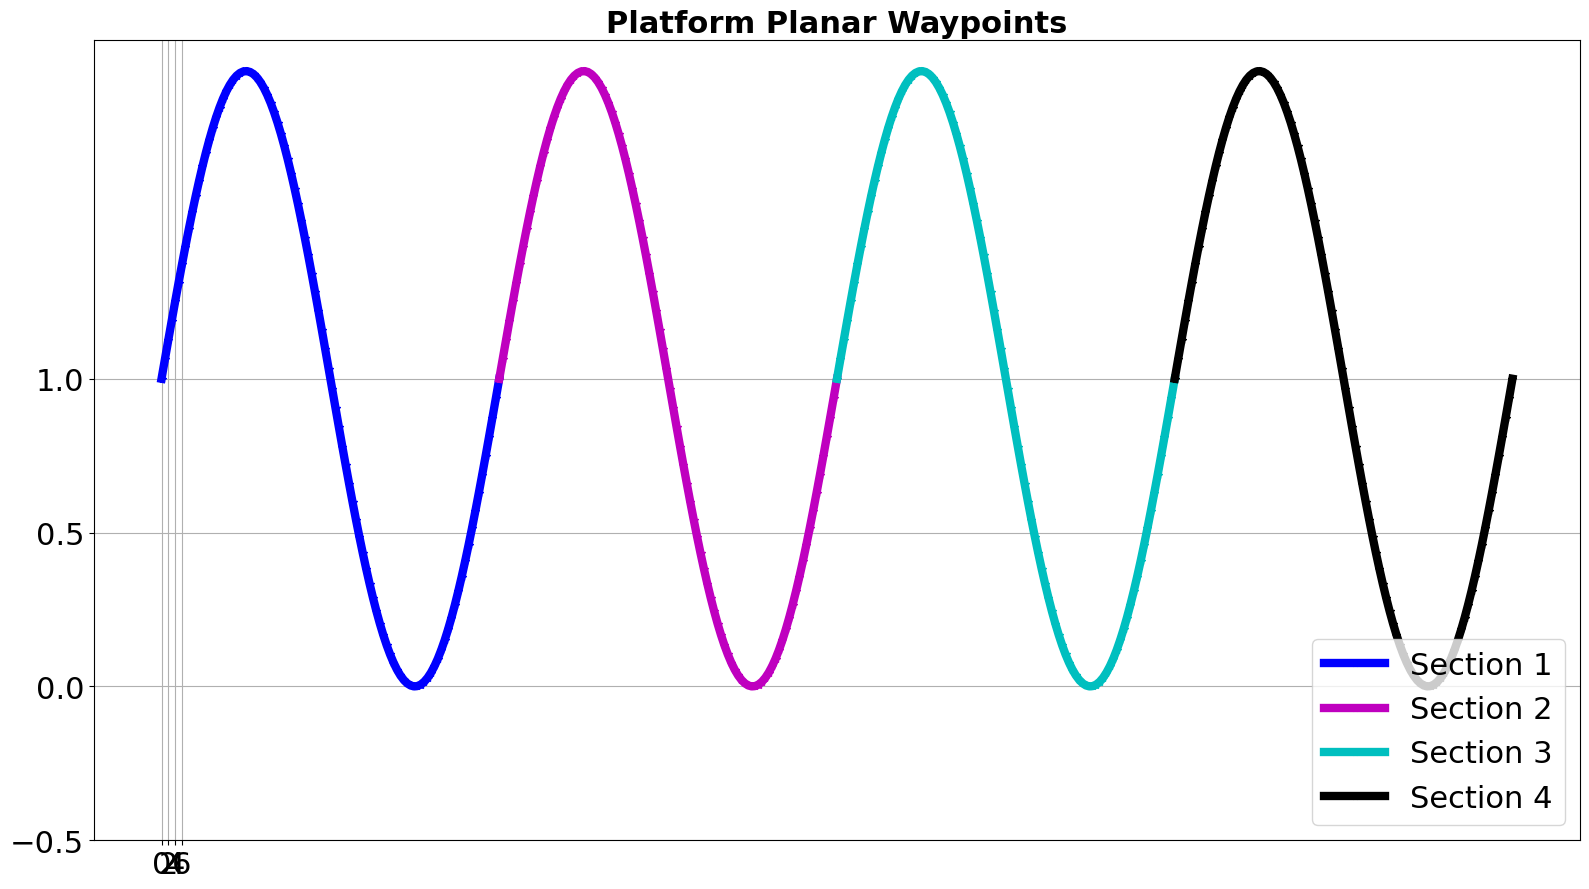

In [10]:
t = np.linspace(0, 100, 100)
r = 1 + np.sin(2*np.pi*t)

winsize = (16,9)
fig = plt.figure(figsize=winsize)
ax = fig.add_subplot(111) #, projection='3d')
labelsize = 22
fontdict = {'fontsize':22, 'fontweight':'bold'}

colors = ['blue', 'red', 'yellow', 'orange', 'green', 'black']
plt.plot(t, r,  'b-*', linewidth=6, label='Section 1') #, color=colors[0])
plt.plot(t+100, r,  'm-*', linewidth=6, label='Section 2') #, color=colors[1])
plt.plot(t+200, r,  'c-*', linewidth=6, label='Section 3') #, color=colors[1])
plt.plot(t+300, r,  'k-*', linewidth=6, label='Section 4') #, color=colors[1])

plt.grid('on')
plt.title("Reference Trajectories")

# Decorations
plt.grid('on')
plt.title('Platform Planar Waypoints', fontdict)

# legends
plt.legend(loc='lower right', fontsize=labelsize)

# gcas
plt.gca().xaxis.set_tick_params(labelsize=labelsize)
plt.gca().yaxis.set_tick_params(labelsize=labelsize)
plt.yticks([ -0.5, 0., 0.5, 1])
plt.xticks([ 0., 2, 4, 6])
plt.tight_layout()

# save the jawn
plot_dump_dir = join(expanduser('~'), 'Documents', 'Papers', 'Pubs23', 'SoRoBC', 'figures')
plt.savefig(join(plot_dump_dir, 'waypoints.jpg'), bbox_inches='tight')
plt.show()

### Trace a Mobius Strip for the continuum to follow in Task space


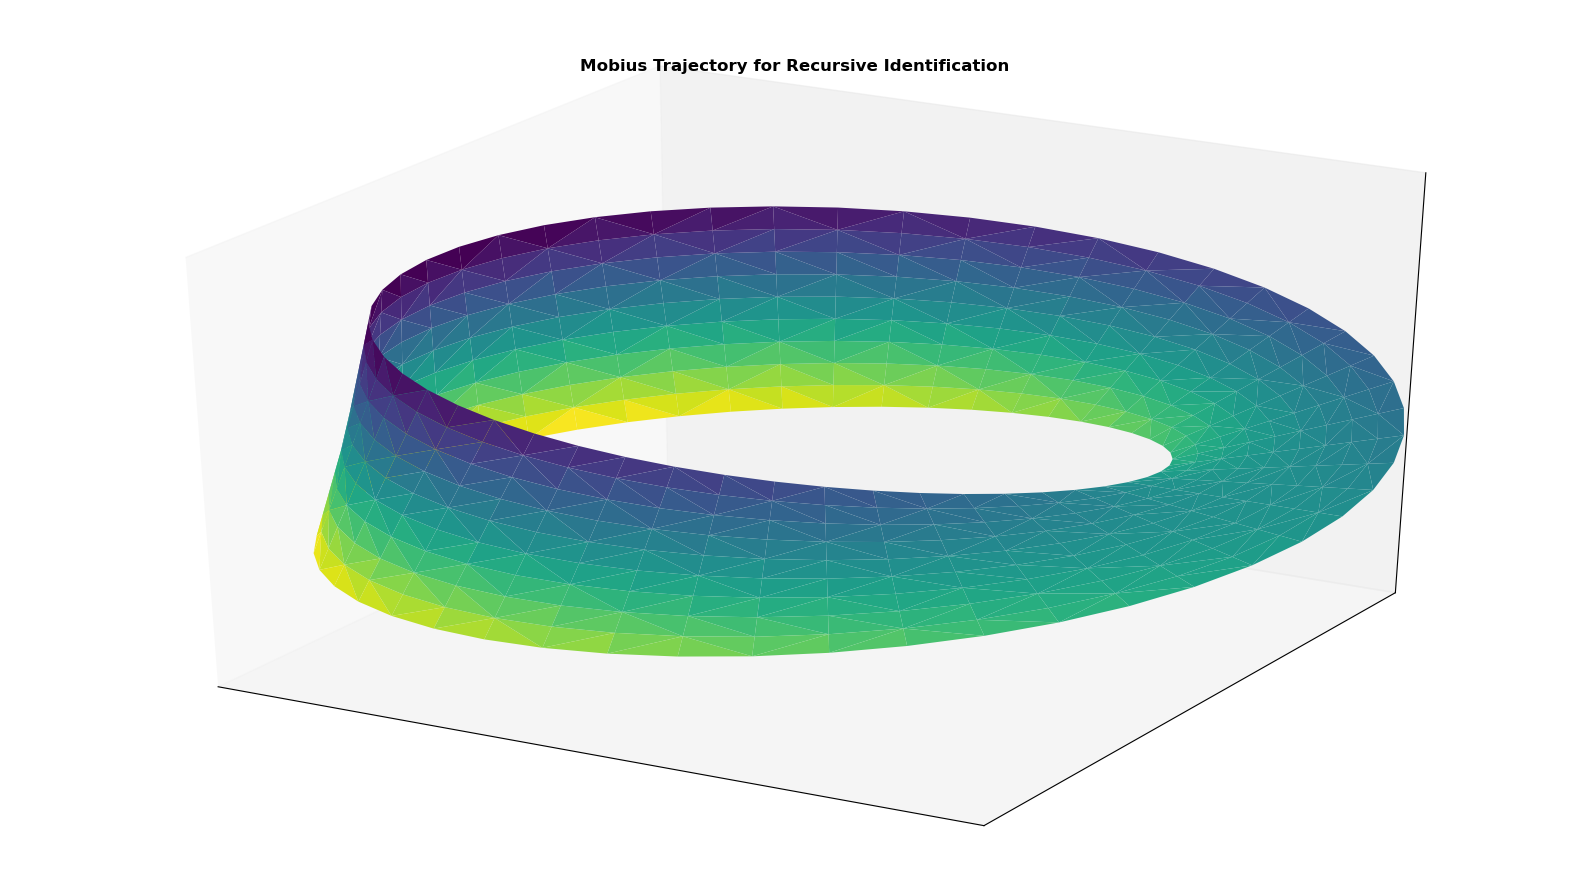

In [ ]:
fig = plt.figure(figsize=(16,9))

# Triangulate parameter space to determine the triangles
u, v = mobius.uv
x,y,z = mobius.xyz
import matplotlib.tri as mtri
tri = mtri.Triangulation(u, v)

# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.30
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.viridis_r)

# Decorations
plt.grid('off')
plt.title('Mobius Trajectory for Recursive Identification', fontdict)

# legends
#ax.legend(rf'$\tau_1$', loc='best', fontsize=labelsize)

# gcas
plt.gca().xaxis.set_tick_params(labelsize=labelsize)
plt.gca().yaxis.set_tick_params(labelsize=labelsize)
plt.gca().zaxis.set_tick_params(labelsize=labelsize)

# plt.yticks([  0.3])
# plt.xticks([  -0.9])
# ax.set_zticks([ 0])
plt.yticks([ ])
plt.xticks([ ])
ax.set_zticks([ ])

ax.set_xlim(-0.9, 0.9)
ax.set_ylim(-0.9, 0.9)
ax.set_zlim(-0.5, 0.5)

# ax.set_xlabel('x', fontdict=fontdict)
# ax.set_ylabel('y', fontdict=fontdict)
# ax.set_zlabel('z', fontdict=fontdict)
plt.tight_layout()

# save the jawn
plt.savefig(join(plot_dump_dir, 'mobius.jpg'), bbox_inches='tight')
plt.show()